In [0]:
rm -rf RAVDESS 

In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [0]:
# Download the pre processed data set
# file_id = '1a2TRcqj5ySMWwetfU3Zgq4FE-highOKK'
file_id = '1l8pPuX0SKPx9wnIfYeP7NZ-jTsNBd4nu'


destination = 'RAVDESS.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [4]:
!ls -lh

total 154M
-rw-r--r-- 1 root root 154M Dec 15 19:41 RAVDESS.zip
drwxr-xr-x 1 root root 4.0K Dec 12 16:48 sample_data


In [5]:
!unzip -n RAVDESS.zip

Archive:  RAVDESS.zip
   creating: RAVDESS/train_valid/
   creating: RAVDESS/train_valid/test/
   creating: RAVDESS/train_valid/test/surprised/
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-01-02-01-09-300.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-01-01-01-13-0.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-02-02-01-04-100.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-01-01-02-14-0.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-01-02-02-05-0.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-01-02-02-01-100.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-01-01-01-06-0.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-02-02-02-11-97.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-01-02-01-08-223.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-02-01-02-02-100.png  
  inflating: RAVDESS/train_valid/test/surprised/03-01-08-01-01-01-08-223.pn

In [6]:
!ls RAVDESS/train_valid/test -lh

total 32K
drwxr-xr-x 2 root root 4.0K Dec  8 14:30 angry
drwxr-xr-x 2 root root 4.0K Dec  8 14:30 calm
drwxr-xr-x 2 root root 4.0K Dec  8 14:30 disgust
drwxr-xr-x 2 root root 4.0K Dec  8 14:30 fearful
drwxr-xr-x 2 root root 4.0K Dec  8 14:30 happy
drwxr-xr-x 2 root root 4.0K Dec  8 14:30 neutral
drwxr-xr-x 2 root root 4.0K Dec  8 14:30 sad
drwxr-xr-x 2 root root 4.0K Dec  8 14:30 surprised


In [0]:
 # Base imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import os
import skimage.io as io
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# keras imports
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, \
    Conv1D, Input, BatchNormalization, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers


# Set seed value
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
def log(model, history,):
    files = os.listdir()
    count = len(list(filter(lambda x: x[:len('log')] =='log', files)))+1
    print(count)
    with open('log_'+str(count)+ '.txt','w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        model.summary(print_fn=lambda x: fh.write(x + '\n'))
        acc = history.history['acc']
        val_acc = history.history['val_acc']

        loss = history.history['loss']
        val_loss = history.history['val_loss']
        for i in range(len(acc)):
            print(i,acc[i],val_acc[i], loss[i],val_loss[i], sep=',', file=fh)

In [0]:
# create directory path helper variables
base_dir = 'RAVDESS/train_valid/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [10]:
print("Number of original train images: " + str(sum([len(files) for r, d, files in os.walk(train_dir)])))
print("Number of original validation images: " + str(sum([len(files) for r, d, files in os.walk(validation_dir)])))
print("Number of original test images: " + str(sum([len(files) for r, d, files in os.walk(test_dir)])))

Number of original train images: 4931
Number of original validation images: 615
Number of original test images: 621


In [0]:
img_height=128
img_width=200

In [0]:
emotions = {
    "neutral": 0, 
    "calm": 1, 
    "happy": 2, 
    "sad": 3, 
    "angry": 4, 
    "fearful":5, 
    "disgust":6 , 
    "surprised":7}
# Train
X_train = []
y_train = []
for r, d, files in os.walk(train_dir):
    if files != [] :
        emotion = r[r.rfind('/')+1:]
        emotion = emotions[emotion]
        count = 0
        for file in files: 
            img = io.imread(r+ '/' +file , as_gray=True)
            img = img.reshape([img_height, img_width, 1])
            X_train.append(img)
            y_train.append(emotion)
            count += 1
            # if count > 200: break
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = np_utils.to_categorical(y_train, 8)
# Valid
X_valid = []
y_valid = []
for r, d, files in os.walk(validation_dir):
    if files != [] :
        emotion = r[r.rfind('/')+1:]
        emotion = emotions[emotion]
        for file in files: 
            img = io.imread(r+ '/' +file , as_gray=True)
            img = img.reshape([img_height, img_width, 1])
            X_valid.append(img)
            y_valid.append(emotion)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
y_valid = np_utils.to_categorical(y_valid, 8)
# Test
X_test = []
y_test = []
for r, d, files in os.walk(test_dir):
    if files != [] :
        emotion = r[r.rfind('/')+1:]
        emotion = emotions[emotion]
        for file in files: 
            img = io.imread(r+ '/' +file , as_gray=True)
            img = img.reshape([img_height, img_width, 1])
            X_test.append(img)
            y_test.append(emotion)
X_test = np.array(X_test)
y_test = np.array(y_test)
# y_test = np_utils.to_categorical(y_test, 8)

In [0]:
ind = np.arange(len(X_train))
np.random.shuffle(ind)
X_train = X_train[list(ind),:]
y_train = y_train[list(ind),:]

ind = np.arange(len(X_valid))
np.random.shuffle(ind)
X_valid = X_valid[list(ind),:]
y_valid = y_valid[list(ind),:]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







Number of parameters:  12461576
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4931 samples, validate on 615 samples
Epoch 1/250
4931/4931 [==============================] - 13s 3ms/step - loss: 4.2269 - acc: 0.1426 - val_loss: 2.4159 - val_acc: 0.1545
Epoch 2/250
4931/4931 [==============================] - 8s 2ms/step - loss: 2.3576 - acc: 0.1568 - val_loss: 2.3314 - val_acc: 0.1545
Epoch 3/250
4931/4931 [==============================] - 8s 2ms/step - loss: 2.2929 - acc: 0.1553 - val_loss: 2.2703 - val_acc: 0.1545
Epoch 4/250
4931/4931 [==============================] - 8s 2ms/step - loss: 2.2539 - acc: 0.1710 - val_loss: 2.2412 - val_acc: 0.1772
Epoch 5/250
4931/4931 [==============================] - 8s 2ms/step - loss: 2.2145 - acc: 0.1914 - val_loss: 2.2168 - val_acc: 0.2228
Epoch 6/250
4931/4931 [=

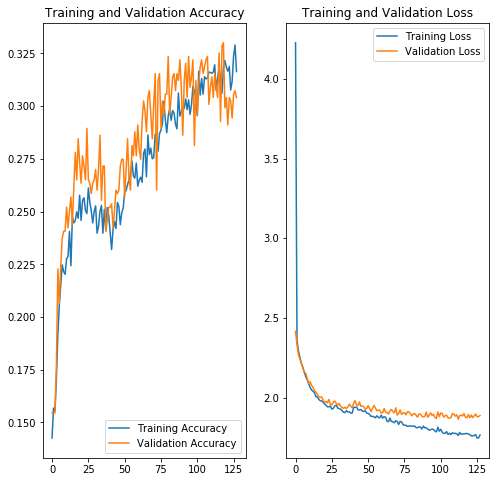

In [15]:
batch_size = 128
num_classes = 8
epochs = 250
best_model_path = 'best_model.h5'
model = Sequential() 
model.add(Conv2D(64, kernel_size=(2, 2),  activation='relu' , input_shape=(128,200,1,),kernel_regularizer=regularizers.l1_l2(0.00001,0.05))) # 
model.add(Dropout(0.35))
model.add(Conv2D(64, (2, 2), activation='relu',kernel_regularizer=regularizers.l1_l2(0.0001,0.005))) 
model.add(Dropout(0.35))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(0,0.000001))) # 
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'] ) #
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', mode='min', save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0)
callbacks = [earlystopping, model_checkpoint]
sum = 0
for i in model.get_weights():
    sum += (np.size(i))
print('Number of parameters: ',sum)
history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_valid,y_valid),callbacks=callbacks,verbose=1)
log(model, history,)
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
saved_model = load_model(best_model_path)

In [0]:
y_pred_classes = saved_model.predict_classes(X_test)

In [0]:
y_pred_classes = saved_model.predict_classes(X_test)

emotions_confusion_matrix = confusion_matrix(y_test, y_pred_classes)
# print(classification_report(y_test_classes, y_pred_classes, target_names=emotions))

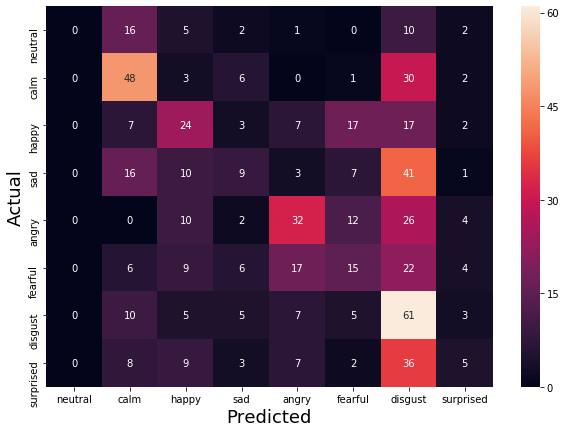

In [40]:
emotion_confusion_df = pd.DataFrame(emotions_confusion_matrix, index = emotions,
                  columns = emotions)
plt.figure(figsize = (10,7))
sn.heatmap(emotion_confusion_df, annot=True)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.show()

In [39]:
emotion_confusion_df

,neutral,calm,happy,sad,angry,fearful,disgust,surprised
neutral,0,16,5,2,1,0,10,2
calm,0,48,3,6,0,1,30,2
happy,0,7,24,3,7,17,17,2
sad,0,16,10,9,3,7,41,1
angry,0,0,10,2,32,12,26,4
fearful,0,6,9,6,17,15,22,4
disgust,0,10,5,5,7,5,61,3
surprised,0,8,9,3,7,2,36,5
